#Pass flow example with StatsBomb open data
Charles William - https://twitter.com/openGoalCharles


DISCLAIMER - THE FLOW VALUES AND PATHS LOOK VAGUELY SENSIBLE BASED ON COMPARISON WITH THE STATIC VECTORS BASED ON THE SMALL NUMBER OF TEST EXAMPLES I HAVE RUN - PLEASE CHECK THE VALIDITY OF STREAMLINES PRODUCED WITH YOUR OWN DATA SET 

Install imagemagick and python packages for pitch plotting and accessing data respectively.

In [ ]:
!apt install imagemagick
!pip install mplsoccer
!pip install statsbombpy

Import data handling and plotting requirements

In [ ]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
from matplotlib.collections import LineCollection
import pandas as pd
from mplsoccer.pitch import Pitch, add_image
from mplsoccer.statsbomb import read_event, EVENT_SLUG
from statsbombpy import sb
import PIL
from urllib.request import urlopen


Load matches from StatsBomb API. We'll select La Liga season 2019/20

In [ ]:
matches = sb.matches(competition_id=11, season_id=42)
match_files = [str(match)+'.json' for match in matches['match_id']]

#we'll use mplsoccer to organise the data from each match file into a single dataframe
kwargs = {'related_event_df': False, 'shot_freeze_frame_df': False, 'tactics_lineup_df': False, 'warn': False}
df = pd.concat([read_event(f'{EVENT_SLUG}/{file}', **kwargs)['event'] for file in match_files])

credentials were not supplied. open data access only


This is the first part of the core stream line plotting code - the Streamlines class. Used as per the licence below from http://web.mit.edu/speth/Public/streamlines.py




In [ ]:
class Streamlines(object):
    """
    Copyright (c) 2011 Raymond Speth.
    Permission is hereby granted, free of charge, to any person obtaining a
    copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, sublicense,
    and/or sell copies of the Software, and to permit persons to whom the
    Software is furnished to do so, subject to the following conditions:
    The above copyright notice and this permission notice shall be included in
    all copies or substantial portions of the Software.
    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
    FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
    DEALINGS IN THE SOFTWARE.
    See: http://web.mit.edu/speth/Public/streamlines.py
    """

    def __init__(self, X, Y, U, V, res=0.125,
                 spacing=1, maxLen=2500, detectLoops=False):
        """
        Compute a set of streamlines covering the given velocity field.
        X and Y - 1D or 2D (e.g. generated by np.meshgrid) arrays of the
                  grid points. The mesh spacing is assumed to be uniform
                  in each dimension.
        U and V - 2D arrays of the velocity field.
        res - Sets the distance between successive points in each
              streamline (same units as X and Y)
        spacing - Sets the minimum density of streamlines, in grid points.
        maxLen - The maximum length of an individual streamline segment.
        detectLoops - Determines whether an attempt is made to stop extending
                      a given streamline before reaching maxLen points if
                      it forms a closed loop or reaches a velocity node.
        Plots are generated with the 'plot' or 'plotArrows' methods.
        """

        self.spacing = spacing
        self.detectLoops = detectLoops
        self.maxLen = maxLen
        self.res = res

        xa = np.asanyarray(X)
        ya = np.asanyarray(Y)
        self.x = xa if xa.ndim == 1 else xa[0]
        self.y = ya if ya.ndim == 1 else ya[:,0]
        self.u = U
        self.v = V
        self.dx = (self.x[-1]-self.x[0])/(self.x.size-1) # assume a regular grid
        self.dy = (self.y[-1]-self.y[0])/(self.y.size-1) # assume a regular grid
        self.dr = self.res * np.sqrt(self.dx * self.dy)

        # marker for which regions have contours
        self.used = np.zeros(self.u.shape, dtype=bool)
        self.used[0] = True
        self.used[-1] = True
        self.used[:,0] = True
        self.used[:,-1] = True

        # Don't try to compute streamlines in regions where there is no velocity data
        for i in range(self.x.size):
            for j in range(self.y.size):
                if self.u[j,i] == 0.0 and self.v[j,i] == 0.0:
                    self.used[j,i] = True

        # Make the streamlines
        self.streamlines = []
        while not self.used.all():
            nz = np.transpose(np.logical_not(self.used).nonzero())
            # Make a streamline starting at the first unrepresented grid point
            self.streamlines.append(self._makeStreamline(self.x[nz[0][1]],
                                                         self.y[nz[0][0]]))


    def _interp(self, x, y):
        """ Compute the velocity at point (x,y) """
        i = (x-self.x[0])/self.dx
        ai = i % 1

        j = (y-self.y[0])/self.dy
        aj = j % 1

        i, j = int(i), int(j)
        
        # Bilinear interpolation
        u = (self.u[j,i]*(1-ai)*(1-aj) +
             self.u[j,i+1]*ai*(1-aj) +
             self.u[j+1,i]*(1-ai)*aj +
             self.u[j+1,i+1]*ai*aj)

        v = (self.v[j,i]*(1-ai)*(1-aj) +
             self.v[j,i+1]*ai*(1-aj) +
             self.v[j+1,i]*(1-ai)*aj +
             self.v[j+1,i+1]*ai*aj)

        self.used[j:j+self.spacing,i:i+self.spacing] = True

        return u,v

    def _makeStreamline(self, x0, y0):
        """
        Compute a streamline extending in both directions from the given point.
        """

        sx, sy = self._makeHalfStreamline(x0, y0, 1) # forwards
        rx, ry = self._makeHalfStreamline(x0, y0, -1) # backwards

        rx.reverse()
        ry.reverse()

        return rx+[x0]+sx, ry+[y0]+sy

    def _makeHalfStreamline(self, x0, y0, sign):
        """
        Compute a streamline extending in one direction from the given point.
        """

        xmin = self.x[0]
        xmax = self.x[-1]
        ymin = self.y[0]
        ymax = self.y[-1]

        sx = []
        sy = []

        x = x0
        y = y0
        i = 0
        while xmin < x < xmax and ymin < y < ymax:
            u, v = self._interp(x, y)
            theta = np.arctan2(v,u)

            x += sign * self.dr * np.cos(theta)
            y += sign * self.dr * np.sin(theta)
            sx.append(x)
            sy.append(y)

            i += 1

            if self.detectLoops and i % 10 == 0 and self._detectLoop(sx, sy):
                break

            if i > self.maxLen / 2:
                break

        return sx, sy

    def _detectLoop(self, xVals, yVals):
        """ Detect closed loops and nodes in a streamline. """
        x = xVals[-1]
        y = yVals[-1]
        D = np.array([np.hypot(x-xj, y-yj)
                      for xj,yj in zip(xVals[:-1],yVals[:-1])])
        return (D < 0.9 * self.dr).any()

* Filter the complete passes only and keep only the columns we are interested in
* Calculate the distance from pass start to pass end for x and y component
* Define the number bins used for calculating the streamlines
* Set the StatsBomb pitch dimensions
* Bin the passes into 2D bins
* Create the "velocity" values as a grid for x and y components. Here velocity is yards per pass

In [ ]:
event_frame_passes = df[(df['type_name'] == 'Pass') & (df['outcome_name'] != 'Incomplete') ][['team_name', 'x', 'y', 'end_x', 'end_y']]

event_frame_passes = event_frame_passes[event_frame_passes['team_name'] == 'Barcelona']

#event_frame_passes = df.reset_index().pivot(columns='qual_name', index=['event_id', 'x', 'y'], values='value')

event_frame_passes.reset_index(inplace=True)
event_frame_passes['dist_x'] = event_frame_passes['end_x'] - event_frame_passes['x']
event_frame_passes['dist_y'] = event_frame_passes['end_y'] - event_frame_passes['y']

xbins = 16
ybins = 16

pitch_x = 120
pitch_y = 80

xgroups = pd.cut(event_frame_passes['x'], np.arange(0, pitch_x+(pitch_x/xbins), pitch_x/xbins))
ygroups = pd.cut(event_frame_passes['y'], np.arange(0, pitch_y+(pitch_y/ybins), pitch_y/ybins))
grouped = event_frame_passes.groupby([xgroups,ygroups]).mean()
grouped = grouped[['dist_x', 'dist_y']]


grouped_distx = grouped.reset_index().pivot(columns = 'x', values = 'dist_x', index = 'y')
grouped_disty = grouped.reset_index().pivot(columns = 'x', values = 'dist_y', index = 'y')
xarr = np.array(grouped_distx)
yarr = np.array(grouped_disty)

The second part of the core streamline generating code, used and adapted as per the licence below from https://github.com/rougier/windmap

The output of this cell will be a single frame of the plot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in remainder


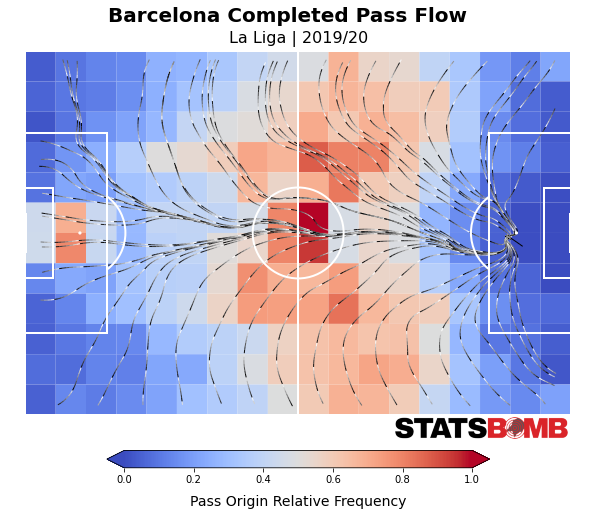

In [ ]:
"""Copyright (c) 2018, Nicolas P. Rougier
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE."""

xbinsj = 16j # by specifying nj we're telling mgrid to create n points between the start and stop value
ybinsj = 16j

#create grid points such that they are at the mid point of the bins we defined earlier
Y, X = np.mgrid[0+(pitch_y/(2*ybins)):pitch_y-(pitch_y/(2*ybins)):ybinsj, 0+(pitch_x/(2*xbins)):pitch_x-(pitch_x/(2*xbins)):xbinsj] # we want mid-point of the bins on the grid

U, V = xarr, yarr

##### PLOTTING #######
fig, ax = plt.subplots(1, 1, figsize=(12,8))

pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_color='white', linewidth=2, line_zorder=10)
pitch.draw(ax=ax)

#define the bins to be used for the heatmap overlay
heat_bins = (18, 12)

# plot the heatmap - darker colors = more passes originating from that square
bs_heatmap = pitch.bin_statistic(event_frame_passes.x.astype(float), event_frame_passes.y.astype(float), statistic='count', bins=heat_bins)

bs_heatmap['statistic'] = bs_heatmap['statistic'] / bs_heatmap['statistic'].max()

hm = pitch.heatmap(bs_heatmap, ax=ax, cmap='coolwarm', edgecolors = 'whitesmoke', linewidth = 0, antialiased = True)

cbar = plt.colorbar(hm,ax=ax, extend = 'both', fraction=0.04, pad=0.04, orientation = 'horizontal')
cbar.set_label('Pass Origin Relative Frequency', labelpad = 10, fontsize = 14)

plt.suptitle('Barcelona Completed Pass Flow', size = 20, x = 0.5, y = 0.925, fontweight = 'bold')
plt.title('La Liga | 2019/20', size = 16, pad = -10)

# load the StatsBomb logo
sb_logo = PIL.Image.open(urlopen(('https://github.com/statsbomb/open-data/blob/fb54bd7fe20dbd5299fafc64f1f6f0d919a5e40d/'
                              'stats-bomb-logo.png?raw=true')))

add_image(sb_logo, fig, left=0.625, bottom=0.175, width=0.2)
########################

lengths = []
colors = []
lines = []

# Streamline plotting and shading
s = Streamlines(X, Y, U, V)
for streamline in s.streamlines:
    x, y = streamline
    y = [pitch_y-i for i in y] # need to invert y axis for statsbomb as 0,0 is top-left
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    n = len(segments)
    
    D = np.sqrt(((points[1:] - points[:-1])**2).sum(axis=-1))
    L = D.cumsum().reshape(n,1) + np.random.uniform(0,1)
    C = np.zeros((n,3))
    C[:] = (L*1.5) % 1

    line = LineCollection((segments), color=C, linewidth=1)
    lengths.append(L)
    colors.append(C)
    lines.append(line)
    
    ax.add_collection(line)

# Update function for animation
def update(frame_no):
    for i in range(len(lines)):
        lengths[i] += 0.05
        colors[i][:] = (lengths[i]*1.5) % 1
        lines[i].set_color(colors[i])
    pbar.update()  


    

Set the number of frames for the animation and gif (or mp4) settings. Save to the current working directory

In [ ]:
n = 27 # This appears to be the magic number to get seamless looping

animation = FuncAnimation(fig, update, frames=n, interval=2)
pbar = tqdm.tqdm(total=n)

#animation.save('pass_flow.mp4', writer='ffmpeg', fps=10)
animation.save('pass_flow.gif', writer='imagemagick', fps=20)

pbar.close()
plt.show()

  0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in remainder
28it [00:19,  1.45it/s]


This is where it gets a bit weird - the flow of the lines doesn't seem intuitive for this use case where we want the flowing animation effect to represent direction of passes...

...so we'll reverse the gif

In [ ]:
from PIL import Image, ImageSequence
im = Image.open('pass_flow.gif')
frames = [frame.copy() for frame in ImageSequence.Iterator(im)]
frames.reverse()
frames[0].save('reversed_pass_flow.gif', save_all=True, append_images=frames[1:], loop=0)

View the finished animation

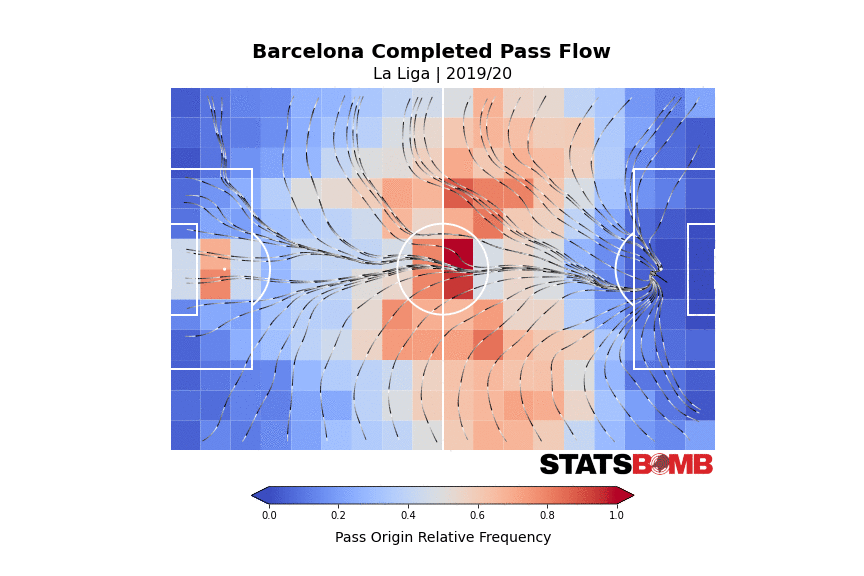

In [ ]:
from IPython.display import Image
Image(open('reversed_pass_flow.gif','rb').read())